c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framewo

Classes: ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']
Total de imagens: 18632


,count
complex,2151
frog_eye_leaf_spot,4352
healthy,4624
powdery_mildew,1271
rust,2077
scab,5712


,num_imagens
n_labels,
1,17277
2,1155
3,200


Ausentes por coluna:


image          0
labels         0
labels_list    0
y              0
n_labels       0
dtype: int64

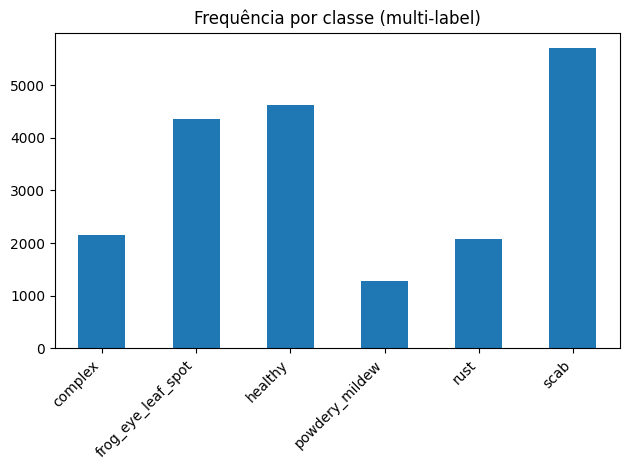

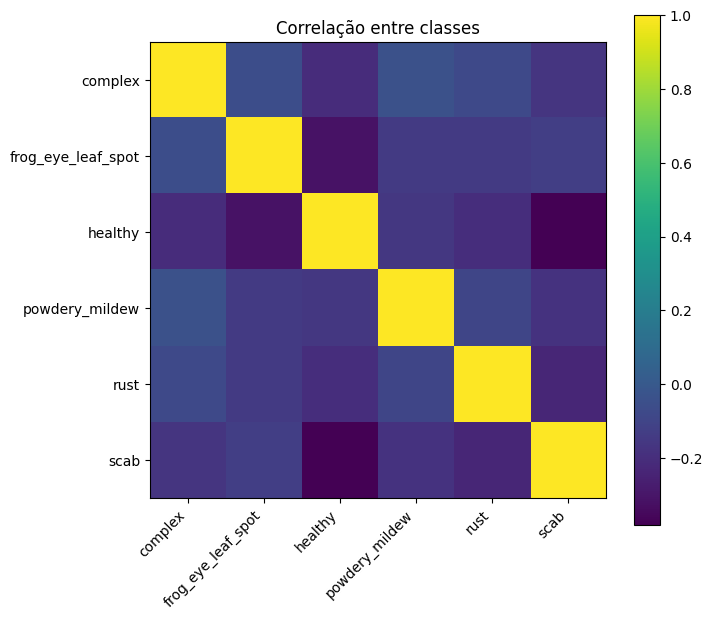

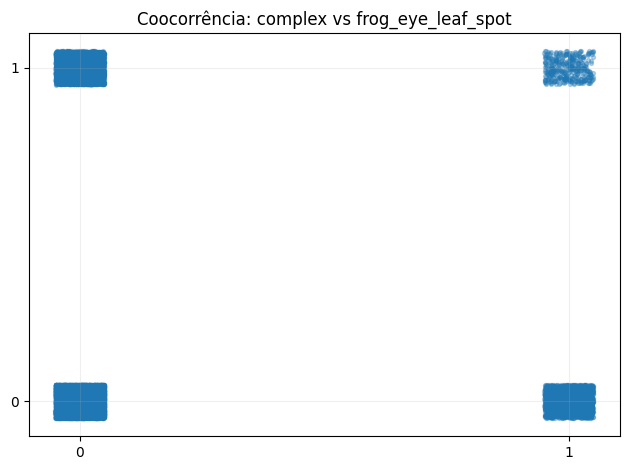

Tamanhos → train: 13063, val: 2773, test: 2796
Found 13063 validated image filenames.
Found 2773 validated image filenames.
Found 2796 validated image filenames.
Batch shapes → X: (32, 224, 224, 3) | y: (32, 6)


c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - AUC: 0.6777 - Precision: 0.3673 - Recall: 0.0115 - loss: 0.4433 - val_AUC: 0.7288 - val_Precision: 0.6875 - val_Recall: 0.0036 - val_loss: 0.4236
Epoch 2/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - AUC: 0.7382 - Precision: 0.5005 - Recall: 0.0357 - loss: 0.4158 - val_AUC: 0.7702 - val_Precision: 0.6089 - val_Recall: 0.0360 - val_loss: 0.4028
Epoch 3/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - AUC: 0.7581 - Precision: 0.5594 - Recall: 0.0563 - loss: 0.4062 - val_AUC: 0.7784 - val_Precision: 0.6250 - val_Recall: 0.0479 - val_loss: 0.3967
Epoch 4/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - AUC: 0.7655 - Precision: 0.5664 - Recall: 0.0616 - loss: 0.4023 - val_AUC: 0.7790 - val_Precision: 0.5476 - val_Recall: 0.0760 - val_loss: 0.3967
Epoch 5/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - AUC: 0.7758 - Precision: 0.5782 - Recall: 0.0782 - loss: 0.3974 - val_AUC: 0.7835 - val_Precision: 0.5578 - val_Recall: 0.1259 - val_loss: 0.3935


KeyboardInterrupt: 

In [1]:
# ===============================
# Notebook Único — Plant Pathology (UEM - AM/MCI)
# Pipeline completo (1 → 8)
# ===============================

# === [0] Imports e Config ===
import os, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(suppress=True)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR   = Path("../data")         # <-- AJUSTE SE PRECISAR
TRAIN_CSV  = DATA_DIR/"train.csv"
TRAIN_DIR  = DATA_DIR/"train_images"
TEST_DIR   = DATA_DIR/"test_images"
assert TRAIN_CSV.exists()
assert TRAIN_DIR.exists()

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS_BASELINE = 5     # comece pequeno; aumente depois
EPOCHS_TL       = 8

# === [1] Escolha e Justificativa do Dataset (Markdown) ===
"""
# 1. Escolha e Justificativa do Dataset
**Fonte**: Kaggle – Plant Pathology 2020 (FGVC7).  
**Link**: https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/data

**Critérios**: 
- Nº de instâncias: > 18k (>=1000)  
- Variáveis relevantes: problema é **multi-label**; cada doença é uma variável binária (0/1): healthy, scab, rust, complex, frog_eye_leaf_spot, powdery_mildew (>=5)

**Justificativa (resumo)**:
- Relevância: diagnóstico de doenças em folhas impacta diretamente produtividade agrícola.
- Aplicação: apoio à decisão via celular/drones em campo.
- Potencial de modelagem: permite CNN, Transfer Learning, ensemble e análise de explicabilidade (Grad-CAM).
"""

# === [2] AED — estatísticas, histogramas, scatter, heatmap, ausentes ===
df = pd.read_csv(TRAIN_CSV)
df.columns = [c.strip().lower() for c in df.columns]
df["labels_list"] = df["labels"].astype(str).str.strip().str.split()
all_labels = sorted({lab for labs in df["labels_list"] for lab in labs})
label2idx = {lab:i for i,lab in enumerate(all_labels)}

def encode_multi_hot(labs):
    v = np.zeros(len(all_labels), dtype=np.float32)
    for lab in labs:
        if lab in label2idx: v[label2idx[lab]] = 1.0
    return v

df["y"] = df["labels_list"].apply(encode_multi_hot)
Y = np.stack(df["y"].values)

print("Classes:", all_labels)
print("Total de imagens:", len(df))

# contagem por classe
cnt = Counter(l for labs in df["labels_list"] for l in labs)
class_freq = pd.Series(cnt).reindex(all_labels).fillna(0).astype(int)
display(class_freq.to_frame("count"))

# nº rótulos por imagem
df["n_labels"] = df["labels_list"].apply(len)
label_card = df["n_labels"].value_counts().sort_index()
display(label_card.to_frame("num_imagens"))

# ausentes
print("Ausentes por coluna:")
display(df.isna().sum())

# plot — histograma classes
plt.figure()
class_freq.plot(kind="bar")
plt.title("Frequência por classe (multi-label)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()
# (sinopse) dataset desbalanceado; minoritárias exigem augmentation/atenção

# heatmap correlação (multi-hot)
corr = np.corrcoef(Y.T)
plt.figure(figsize=(5 + 0.4*len(all_labels), 4 + 0.4*len(all_labels)))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(all_labels)), all_labels, rotation=45, ha="right")
plt.yticks(range(len(all_labels)), all_labels)
plt.title("Correlação entre classes")
plt.tight_layout(); plt.show()
# (sinopse) 'complex' tende a coocorrer com outras; 'healthy' é excludente

# scatter simples (duas primeiras classes)
if len(all_labels) >= 2:
    a, b = all_labels[0], all_labels[1]
    ia, ib = label2idx[a], label2idx[b]
    xa, xb = Y[:,ia], Y[:,ib]
    jitter = 0.05
    plt.figure()
    plt.scatter(xa + np.random.uniform(-jitter, jitter, len(xa)),
                xb + np.random.uniform(-jitter, jitter, len(xb)),
                s=8, alpha=0.3)
    plt.title(f"Coocorrência: {a} vs {b}")
    plt.yticks([0,1]); plt.xticks([0,1])
    plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()
# (sinopse) quadrante (1,1) indica coocorrência das duas doenças

# === [3] Pré-processamento — normalização, augmentation, codificação ===
# Split 70/15/15 com fallback de estratificação
df["primary_label"] = df["labels_list"].apply(lambda labs: labs[0] if len(labs)>0 else "none")
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
    train_idx, temp_idx = next(msss.split(df["image"], Y))
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_temp  = df.iloc[temp_idx].reset_index(drop=True); Y_temp = Y[temp_idx]
    msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
    val_idx, test_idx = next(msss2.split(df_temp["image"], Y_temp))
    df_val  = df_temp.iloc[val_idx].reset_index(drop=True)
    df_test = df_temp.iloc[test_idx].reset_index(drop=True)
except:
    df_train, df_temp = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df["primary_label"])
    df_val, df_test   = train_test_split(df_temp, test_size=0.50, random_state=SEED, stratify=df_temp["primary_label"])
    df_train, df_val, df_test = df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

print(f"Tamanhos → train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")

# Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15, width_shift_range=0.08, height_shift_range=0.08,
    zoom_range=0.12, horizontal_flip=True, fill_mode="nearest"
)
valid_aug = ImageDataGenerator(rescale=1./255)
test_aug  = ImageDataGenerator(rescale=1./255)

# y como colunas (matriz 2D), para class_mode='raw' sair (batch, n_classes)
def make_df_for_flow(df_part, labels):
    df_local = df_part[["image"]].copy()
    df_local["filepath"] = df_local["image"].apply(lambda n: str(TRAIN_DIR / n))
    for lab in labels:
        df_local[f"y_{lab}"] = df_part["y"].apply(lambda v: np.float32(v[label2idx[lab]]))
    return df_local

label_cols = [f"y_{lab}" for lab in all_labels]
df_train_flow = make_df_for_flow(df_train, all_labels)
df_val_flow   = make_df_for_flow(df_val,   all_labels)
df_test_flow  = make_df_for_flow(df_test,  all_labels)

train_flow = train_aug.flow_from_dataframe(
    df_train_flow, x_col="filepath", y_col=label_cols,
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="raw", batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_flow = valid_aug.flow_from_dataframe(
    df_val_flow, x_col="filepath", y_col=label_cols,
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="raw", batch_size=BATCH_SIZE, shuffle=False
)
test_flow = test_aug.flow_from_dataframe(
    df_test_flow, x_col="filepath", y_col=label_cols,
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="raw", batch_size=BATCH_SIZE, shuffle=False
)

steps_train = int(np.ceil(len(df_train_flow)/BATCH_SIZE))
steps_val   = int(np.ceil(len(df_val_flow)/BATCH_SIZE))
steps_test  = int(np.ceil(len(df_test_flow)/BATCH_SIZE))

xb, yb = next(iter(train_flow))
print("Batch shapes → X:", xb.shape, "| y:", yb.shape)

# === [4] Modelagem — (A) Baseline CNN ===
n_classes = len(all_labels)

def build_baseline(input_shape=(224,224,3), n_classes=6):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(128,3, activation="relu"), layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="sigmoid")  # multi-label
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(curve="ROC", name="AUC"),
                 tf.keras.metrics.Precision(name="Precision"),
                 tf.keras.metrics.Recall(name="Recall")]
    )
    return model

baseline = build_baseline((IMG_SIZE[0], IMG_SIZE[1], 3), n_classes)
hist_base = baseline.fit(
    train_flow, validation_data=val_flow,
    epochs=EPOCHS_BASELINE, steps_per_epoch=steps_train, validation_steps=steps_val, verbose=1
)

# === [4b] Modelagem — (B) Transfer Learning (ResNet50) ===
base = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False  # primeiro estágio: congelado
tl = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="sigmoid")
])
tl.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
           loss="binary_crossentropy",
           metrics=[tf.keras.metrics.AUC(curve="ROC", name="AUC"),
                    tf.keras.metrics.Precision(name="Precision"),
                    tf.keras.metrics.Recall(name="Recall")])
hist_tl = tl.fit(
    train_flow, validation_data=val_flow,
    epochs=EPOCHS_TL, steps_per_epoch=steps_train, validation_steps=steps_val, verbose=1
)

# (opcional) fine-tune parcial: descongelar última “n” camadas do backbone e treinar com LR menor

# === [5] Avaliação — funções de métricas (Accuracy, F1, MCC, AUC), curvas e confusão ===
def predict_all(model, flow):
    y_true = np.vstack([y for _,y in flow])  # empilha os batches
    y_pred = model.predict(flow, verbose=0)
    return y_true, y_pred

def binarize(y_scores, thr=0.5):
    return (y_scores >= thr).astype(np.int32)

def f1_macro(y_true, y_pred_bin, eps=1e-8):
    f1s = []
    for k in range(y_true.shape[1]):
        tp = np.sum((y_true[:,k]==1)&(y_pred_bin[:,k]==1))
        fp = np.sum((y_true[:,k]==0)&(y_pred_bin[:,k]==1))
        fn = np.sum((y_true[:,k]==1)&(y_pred_bin[:,k]==0))
        prec = tp/(tp+fp+eps); rec = tp/(tp+fn+eps)
        f1 = 2*prec*rec/(prec+rec+eps)
        f1s.append(f1)
    return float(np.mean(f1s))

def mcc_multilabel(y_true, y_pred_bin, eps=1e-8):
    # média do MCC por classe
    mccs = []
    for k in range(y_true.shape[1]):
        yk = y_true[:,k]; pk = y_pred_bin[:,k]
        tp = np.sum((yk==1)&(pk==1)); tn = np.sum((yk==0)&(pk==0))
        fp = np.sum((yk==0)&(pk==1)); fn = np.sum((yk==1)&(pk==0))
        denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) + eps
        mcc = ((tp*tn)-(fp*fn))/denom
        mccs.append(mcc)
    return float(np.mean(mccs))

# Avaliar baseline e TL no conjunto de teste
y_true_test, y_pred_test_base = predict_all(baseline, test_flow)
y_pred_bin_base = binarize(y_pred_test_base, thr=0.5)

y_true_test2, y_pred_test_tl   = predict_all(tl, test_flow)
y_pred_bin_tl = binarize(y_pred_test_tl, thr=0.5)

# AUC-ROC macro (média por classe)
auc_base = roc_auc_score(y_true_test, y_pred_test_base, average="macro")
auc_tl   = roc_auc_score(y_true_test2, y_pred_test_tl,   average="macro")

f1_base = f1_macro(y_true_test, y_pred_bin_base)
f1_tl   = f1_macro(y_true_test2, y_pred_bin_tl)

mcc_base = mcc_multilabel(y_true_test, y_pred_bin_base)
mcc_tl   = mcc_multilabel(y_true_test2, y_pred_bin_tl)

print("\n=== Métricas (TESTE) ===")
print(f"Baseline → AUC: {auc_base:.4f} | F1-macro: {f1_base:.4f} | MCC: {mcc_base:.4f}")
print(f"ResNet50 → AUC: {auc_tl:.4f} | F1-macro: {f1_tl:.4f} | MCC: {mcc_tl:.4f}")

# Curvas ROC/PR por classe (salva 1 exemplo; você pode laçar todas)
k = 0  # primeira classe
fpr, tpr, _ = roc_curve(y_true_test[:,k], y_pred_test_tl[:,k])
prec, rec, _ = precision_recall_curve(y_true_test[:,k], y_pred_test_tl[:,k])

plt.figure(); plt.plot(fpr, tpr); plt.title(f"ROC — {all_labels[k]} (TL)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True, alpha=0.2); plt.show()
plt.figure(); plt.plot(rec, prec); plt.title(f"Precision-Recall — {all_labels[k]} (TL)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True, alpha=0.2); plt.show()

# Matriz de confusão por classe (multi-label: confusão binária por classe)
def plot_confusion_per_class(y_true, y_pred_bin, class_names):
    for k, name in enumerate(class_names):
        cm = confusion_matrix(y_true[:,k], y_pred_bin[:,k], labels=[0,1])
        plt.figure()
        plt.imshow(cm, cmap="Blues")
        plt.title(f"Matriz de confusão — {name}")
        plt.xticks([0,1], ["Neg(0)","Pos(1)"]); plt.yticks([0,1], ["Neg(0)","Pos(1)"])
        for (i,j),v in np.ndenumerate(cm):
            plt.text(j, i, int(v), ha="center", va="center")
        plt.tight_layout(); plt.show()

plot_confusion_per_class(y_true_test2, y_pred_bin_tl, all_labels)

# Overfitting: comparar curvas de treino/val (ex.: AUC do hist_tl)
plt.figure()
plt.plot(hist_tl.history["AUC"], label="train AUC")
plt.plot(hist_tl.history["val_AUC"], label="val AUC")
plt.title("AUC Treino vs Validação (TL)"); plt.legend(); plt.grid(True, alpha=0.2); plt.show()

# === [6] Explicabilidade — Grad-CAM simples (TL) ===
# Função Grad-CAM (camada conv final do backbone)
def grad_cam(model, img_array, last_conv_layer_name=None):
    # encontra última conv do backbone
    if last_conv_layer_name is None:
        last_conv_layer = [l for l in model.layers[0].layers if isinstance(l, layers.Conv2D)][-1]
        last_conv_layer_name = last_conv_layer.name
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(index=0).get_layer(last_conv_layer_name).output, model.output],
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions, axis=1)  # foco na classe mais ativada
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    return heatmap

# pegar 1 imagem do validation para ilustrar
xb_val, yb_val = next(iter(val_flow))
hm = grad_cam(tl, xb_val[0:1])
plt.figure(); plt.imshow(xb_val[0]); plt.imshow(hm, cmap="jet", alpha=0.35); plt.title("Grad-CAM (TL)"); plt.axis("off"); plt.show()
# (sinopse) mapa destaca regiões da folha que o modelo usou para a decisão


